In [11]:
import numpy as np
import pandas as pd

import sys
import cv2
#from skimage.io import imread, imread_collection
from scipy import signal
import scipy.misc
from scipy.misc import imread
from scipy.ndimage import filters,distance_transform_edt
from matplotlib import pyplot as plt

import os
from os import listdir

from keras.models import Model
from keras import optimizers
from keras.layers import Input,Activation,Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization,Dropout

In [15]:
dir_path='/home/zoro/Desktop/nmumg_data'
main_path=dir_path+'/train_test_data_cla'
path_train_input = main_path+'/train/Img'
path_test_input= main_path+'/test/Img'
path_train_gt = main_path+'/train/BIB'
path_test_gt=main_path+'/test/BIB'


path_predict=dir_path+'/predict'
path_output=dir_path+'/output'

nb_epoch =300
batch_size = 10
weight_file='nmumg_thick_ep300.hdf5'

n_labels =3

In [3]:
def label_map(labels,img_h,img_w):
    label_map = np.zeros([img_h, img_w, n_labels])    
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, labels[r][c]] = 1
    return label_map

In [4]:
def prep_data(path_img,path_gt):
    data = []
    label = []

    img_list = sorted(listdir(path_img))
    gt_list=sorted(listdir(path_gt))
    i=0
    while (i<len(img_list)):
        img = np.array(imread(path_img +'/'+ img_list[i]),dtype=np.float64)
        img=(img-np.amin(img))*1.0/(np.amax(img)-np.amin(img))#img*1.0 transform array to double
        img=img*1.0/np.median(img)
        img_h=img.shape[0]        
        img_w=img.shape[1]
                
        img=np.reshape(img,(img_h,img_w,1))
        #print img.shape 
        data.append(img)  
        
        gt =np.array(imread(path_gt + '/'+ gt_list[i]))
        label.append(label_map(gt,img_h,img_w))
        i+=1
    data, label =np.array(data), np.array(label)
    return data, label     

In [5]:
def prep_prediction_data(path_img):
    data = []
    img_list = sorted(listdir(path_img))
    i=0
    while (i<len(img_list)):
        img = np.array(imread(path_img +'/'+ img_list[i]),dtype=np.float64)
        img=(img-np.amin(img))*1.0/(np.amax(img)-np.amin(img))#img*1.0 transform array to double
        img=img*1.0/np.median(img)
        img_h=img.shape[0]        
        img_w=img.shape[1]
        img=np.reshape(img,(img_h,img_w,1))
        data.append(img)
        i+=1
    data=np.array(data)
    print(data.shape)
    return data

In [7]:
def conv_block(input_tensor, kernel, filters):
    x=Conv2D(filters, (kernel, kernel), padding='same')(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    return x

In [8]:
kernel = 3
#------------encoder layers--------------------------------
inputs = Input((None,None, 1))
conv1=conv_block(inputs,kernel,filters=64)
conv1=conv_block(conv1,kernel,filters=64)
pool1=MaxPooling2D()(conv1)
    
conv2=conv_block(pool1,kernel,filters=128)
conv2=conv_block(conv2,kernel,filters=128)
pool2=MaxPooling2D()(conv2)

conv3=conv_block(pool2,kernel,filters=256)
conv3=conv_block(conv3,kernel,filters=256)
conv3=conv_block(conv3,kernel,filters=256)
pool3=MaxPooling2D()(conv3)

conv4=conv_block(pool3,kernel,filters=512)
conv4=conv_block(conv4,kernel,filters=512)
conv4=conv_block(conv4,kernel,filters=512)
pool4=MaxPooling2D()(conv4)
 
conv5=conv_block(pool4,kernel,filters=512)
conv5=conv_block(conv5,kernel,filters=512)
conv5=conv_block(conv5,kernel,filters=512)
pool5=MaxPooling2D()(conv5)


#--------------------decoder layers--------------------------

up6=UpSampling2D()(pool5)
conv6=conv_block(up6,kernel,filters=512)
conv6=conv_block(conv6,kernel,filters=512)
conv6=conv_block(conv6,kernel,filters=512)

up7=UpSampling2D()(conv6)
conv7=conv_block(up7,kernel,filters=512)
conv7=conv_block(conv7,kernel,filters=512)
conv7=conv_block(conv7,kernel,filters=512)
    
up8=UpSampling2D()(conv7)
conv8=conv_block(up8,kernel,filters=256)
conv8=conv_block(conv8,kernel,filters=256)
conv8=conv_block(conv8,kernel,filters=256)

up9=UpSampling2D()(conv8)
conv9=conv_block(up9,kernel,filters=128)
conv9=conv_block(conv9,kernel,filters=128)

up10=UpSampling2D()(conv9)
conv10=conv_block(up10,kernel,filters=64)

conv11=conv_block(conv10,kernel=1,filters=n_labels)    
#drop11=Dropout(0.5)(conv11)
outputs=Activation('softmax')(conv11)

autoencoder=Model(inputs=[inputs], outputs=[outputs])

autoencoder.summary()

autoencoder.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
print ('Compiled: OK')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 1)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    640       
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 64)    256       
_________________________________________________________________
activation_1 (Activation)    (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 64)    256       
_________________________________________________________________
activation_2 (Activation)    (None, None, None, 64)    0         
__________

In [9]:
train_data, train_label = prep_data(path_train_input,path_train_gt)
print train_data.shape
print train_label.shape

(95, 256, 256, 1)
(95, 256, 256, 3)


In [ ]:
#-----------------train--------------------------
history=autoencoder.fit(train_data, train_label, batch_size=batch_size, epochs=nb_epoch, verbose=1)
autoencoder.save_weights(weight_file)

Epoch 1/2


(1, 640, 640, 1)
(1, 640, 640, 3)
(640, 640)


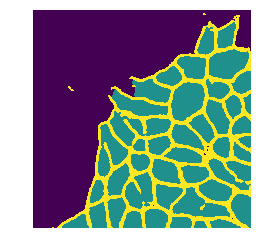

In [16]:
#-----------predict--------------
autoencoder.load_weights(weight_file)
predict_data=prep_prediction_data(path_predict)
output = autoencoder.predict(predict_data, verbose=0)
print(output.shape)

#output_label=np.argmax(output[0],axis=-1)
#im=output[0][:,:,1]
im=np.argmax(output[0],axis=-1)
np.save(path_output+'/thick_out.npy',im)
data=np.load(path_output+'/thick_out.npy')
print(im.shape)

#save image to 8 bit
scipy.misc.imsave(path_output+'/thick_out_8bit.png',im)
#save image to the exat value
img=scipy.misc.toimage(im,high=np.max(im),low=np.min(im),mode='I')
img.save(path_output+'/thick_out_exact.png')


plt.imshow(im)
#plt.colorbar(fig)
plt.axis('off')
plt.savefig(path_output+'/thick_out_300dpi.tif',bbox_inches='tight',format='tif',dpi=300)
plt.show()

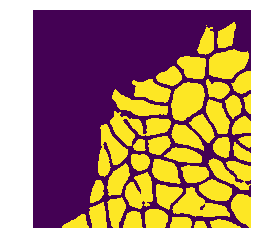

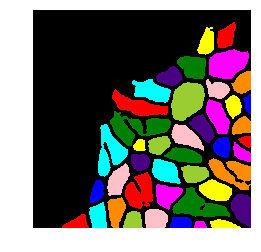

In [17]:
import skimage
from skimage import morphology
from skimage.morphology import disk, square,diamond
from skimage import measure
from skimage.measure import label
from skimage.color import label2rgb

im=im==1
b=np.array(im,bool)
plt.imshow(b)
plt.axis('off')
plt.savefig(path_output+'/thick_inner_out_300dpi.tif',bbox_inches='tight',format='tif',dpi=300)
plt.show()

b=skimage.morphology.opening(b)
L1=label(b)
L2=label2rgb(L1,bg_label=0);
plt.imshow(L2)
plt.axis('off')
plt.savefig(path_output+'/thick_label_300dpi.tif',bbox_inches='tight',format='tif',dpi=300)
plt.show()

#scipy.misc.imsave('/home/zoro/label_output.png',label2rgb(b,bg_color=(0,0,0)))
#scipy.misc.imsave('/home/zoro/label_output.png',b)